In [1]:
import gym
import gym.wrappers
import numpy as np
import logging
import matplotlib.pylab as pl
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [2]:
gym.logger.setLevel(logging.ERROR)
env = gym.make("LunarLander-v2")
# if isinstance(env, gym.wrappers.TimeLimit):
#     env._max_episode_steps = max_steps
#env = gym.wrappers.Monitor(env, "mountaincar-res")

n_actions = env.action_space.n

print("n_actions=%i" % (n_actions))

n_actions=4


In [3]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));

/home/shmuma/sfw/anaconda/envs/pract_rl/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [4]:
def generate_session(t_max=10000):
    states, actions = [], []
    total_reward = 0
    s = env.reset()
    
    for _ in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
            
    return states, actions, total_reward

In [5]:
n_samples = 250
percentile = 50
rewards = []
thresholds = []

In [7]:
percentile = 25
n_samples = 500

In [9]:
for i in range(100):
    #%time 
    sessions = [generate_session() for _ in range(n_samples)]
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    
    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]
    
    if not elite_states.size:
        print("%d: no elite sessions, try again" % i)
        continue
    
    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])
    
    agent.fit(elite_states, elite_actions)
    print("%d: mean reward = %.5f (max: %f)\tthreshold = %.1f" % (
        i, np.mean(batch_rewards), np.max(batch_rewards), threshold))
    thresholds.append(threshold)
    rewards.append(np.mean(batch_rewards))

0: mean reward = -24.00516 (max: 63.841522)	threshold = -37.8
1: mean reward = -20.97138 (max: 72.614478)	threshold = -38.2
2: mean reward = -21.69947 (max: 70.263167)	threshold = -37.1
3: mean reward = -26.15706 (max: 56.056673)	threshold = -45.4
4: mean reward = -19.24701 (max: 68.332609)	threshold = -34.7
5: mean reward = -18.88792 (max: 80.213699)	threshold = -36.5
6: mean reward = -17.39009 (max: 72.901593)	threshold = -33.9
7: mean reward = -24.19222 (max: 71.674331)	threshold = -41.6
8: mean reward = -18.62103 (max: 69.588974)	threshold = -37.5
9: mean reward = -19.16364 (max: 70.726687)	threshold = -36.4
10: mean reward = -13.91797 (max: 147.786197)	threshold = -30.9
11: mean reward = -18.90584 (max: 68.332328)	threshold = -33.0
12: mean reward = -14.93345 (max: 100.716442)	threshold = -31.5
13: mean reward = -13.12802 (max: 106.832325)	threshold = -27.9
14: mean reward = -17.29306 (max: 64.211232)	threshold = -32.7
15: mean reward = -19.39505 (max: 69.847654)	threshold = -31.6

KeyboardInterrupt: 

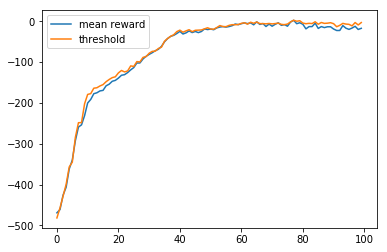

In [8]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()